Shape: (5000, 9)
Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
Using TARGET = 'Glucose'
Mean Squared Error: 979.9569
R² Score: -0.0040


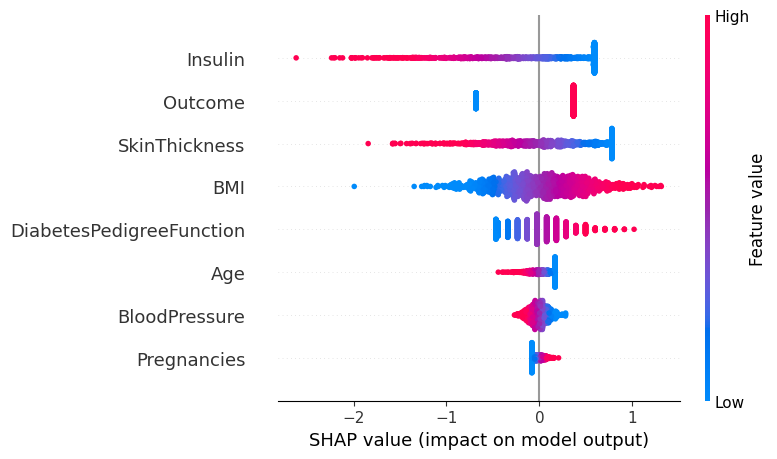

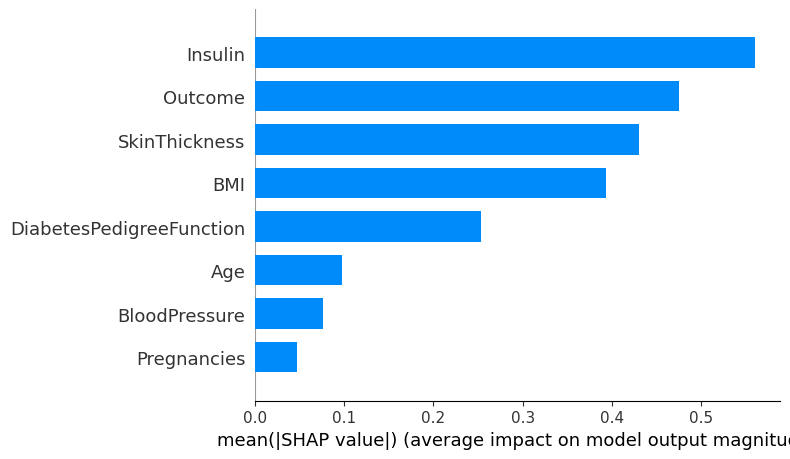


Explaining test instance index: 0


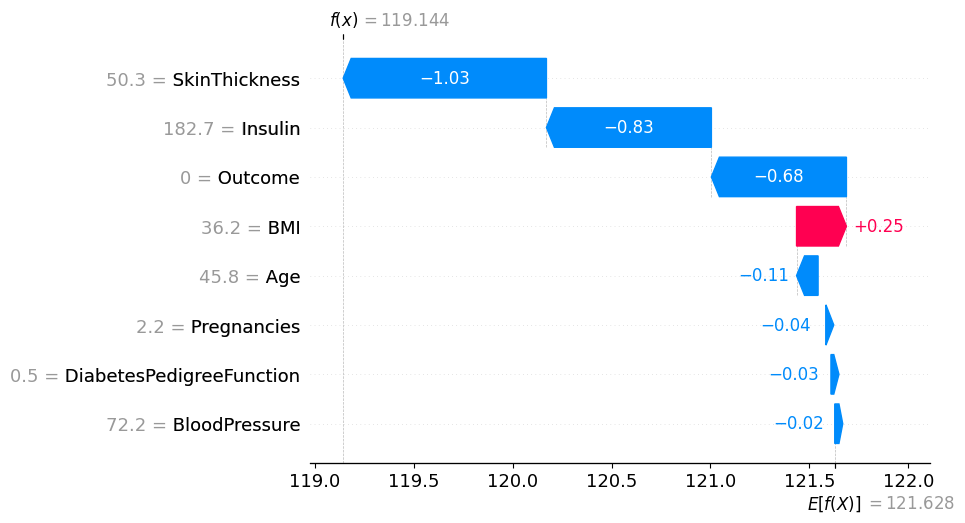

In [ ]:
# !pip install shap scikit-learn pandas matplotlib

import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


csv_path = "Diabetes_ANN.csv"


df = pd.read_csv(csv_path)
print("Shape:", df.shape)
print("Columns:", list(df.columns))


PREFERRED_TARGETS = ["Glucose", "BMI", "Insulin", "BloodPressure", "SkinThickness", "DiabetesPedigreeFunction", "Age"]

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
candidates = [c for c in PREFERRED_TARGETS if c in numeric_cols]
if not candidates:
    # Fallback: pick the first numeric column that isn't clearly binary/class label
    blacklist = {"Outcome", "Label", "Target"}
    remaining = [c for c in numeric_cols if c not in blacklist]
    if not remaining:
        raise ValueError("No suitable numeric target found in the dataset.")
    TARGET = remaining[0]
else:
    TARGET = candidates[0]

print(f"Using TARGET = '{TARGET}'")


feature_cols = [c for c in numeric_cols if c != TARGET]
if len(feature_cols) == 0:
    raise ValueError("No feature columns available after removing target.")

X = df[feature_cols].copy()
y = df[TARGET].copy()

# Basic cleaning
X = X.fillna(0)
y = y.fillna(y.mean())


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")


background = shap.utils.sample(X_train, min(100, len(X_train)), random_state=42)
explainer = shap.Explainer(model.predict, background)

# Compute SHAP values for test set
shap_values = explainer(X_test)

# --- Global: summary (beeswarm) ---
shap.summary_plot(shap_values, X_test, show=True)

# --- Global: bar ranking ---
shap.summary_plot(shap_values, X_test, plot_type="bar", show=True)

# --- Local: explain a single prediction ---
i = 0  # change index to inspect another sample
print(f"\nExplaining test instance index: {i}")
shap.waterfall_plot(shap.Explanation(
    values=shap_values.values[i],
    base_values=shap_values.base_values[i],
    data=X_test.iloc[i],
    feature_names=X_test.columns.tolist()
))
plt.show()


Generating dependence plots for: ['BMI', 'Insulin', 'BloodPressure', 'Age']


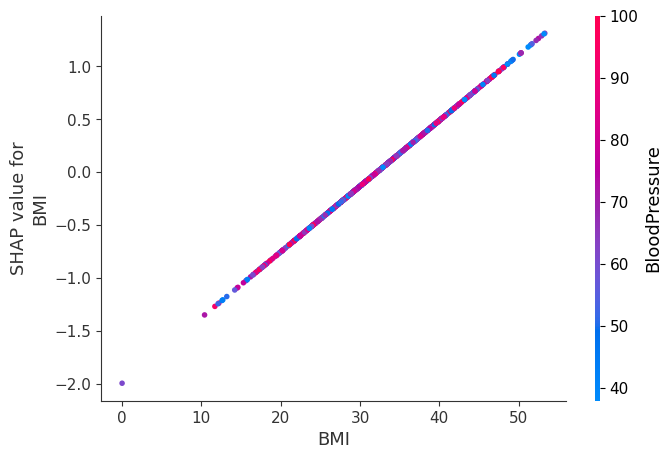

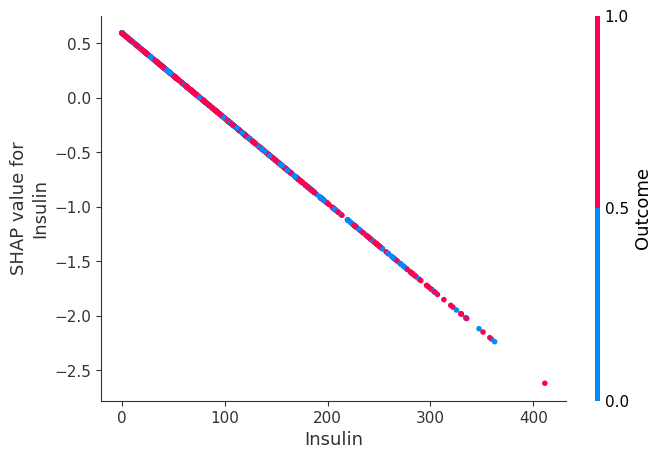

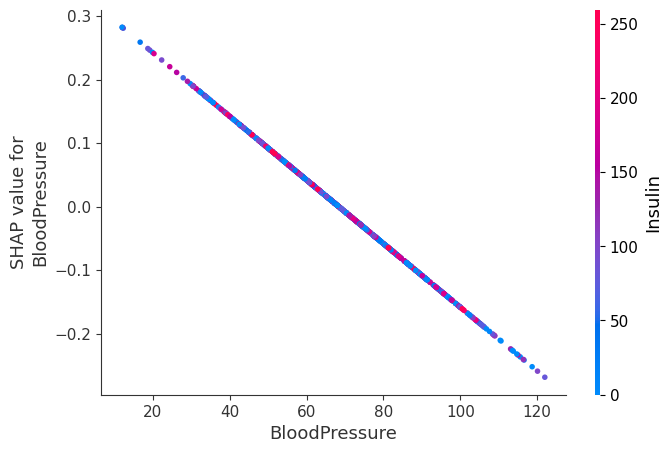

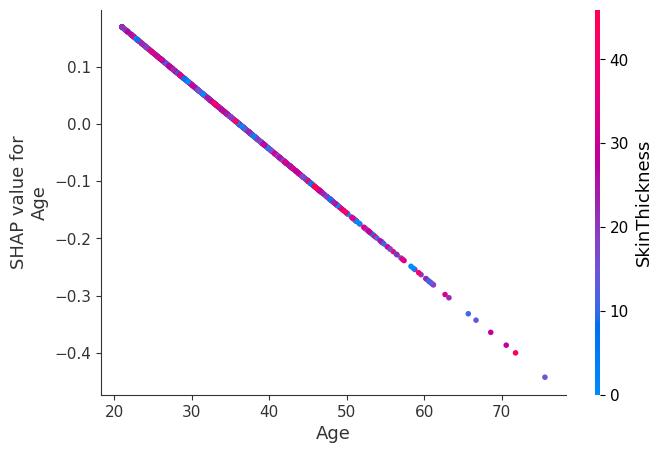

Saved: ['shap_dependence_BMI.png', 'shap_dependence_Insulin.png', 'shap_dependence_BloodPressure.png', 'shap_dependence_Age.png']


In [ ]:
preferred_dep = ["BMI", "Insulin", "BloodPressure", "Age", "Pregnancies"]
selected = [f for f in preferred_dep if f in X_test.columns]
if len(selected) < 4:
    selected += [c for c in X_test.columns if c not in selected]
selected = selected[:4]  # take top 4

print("Generating dependence plots for:", selected)
for feature in selected:
    shap.dependence_plot(
        feature, shap_values.values, X_test, feature_names=X_test.columns
    )
    plt.savefig(f"shap_dependence_{feature}.png", bbox_inches="tight")
    plt.close()

print("Saved:", [f"shap_dependence_{f}.png" for f in selected])